# Boinformatics Note Implementation

## Outline

1. Upload one patient cohort data

2. Plot histogram of protein values across all samples

3. Upload 3 patient cohort data into IntegratedCohort

4. Compute ROC curve using patient biomarker data predicting the treatment (use L1-regularized Logistic Regression model). 

In [1]:
import cohorts
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
top = "./"
data_dirs = { 'my_cohort' : "../data/" }
file_dirs = { 'my_cohort' : top+"sample_data/" }
replicates_files = { 'my_cohort' : "df_replicates.tsv" }
#sample_files = { 'my_cohort' : "df_samples.tsv" }
sample_groups_files = { 'my_cohort' : "df_sample_groups.tsv" }
cohort = { 'my_cohort' : 'my_cohort' }
references = { 'my_cohort' : 'ref' }
treatments = { 'my_cohort' : 'trt' }
cohort_name = 'my_cohort'
c = cohorts.Cohort(cohort=cohort[cohort_name],marker_type="protein",
                       data_dir=data_dirs[cohort_name],file_dir=file_dirs[cohort_name],
                       replicates_file=replicates_files[cohort_name],
                       #sample_files=sample_files[cohort],
                       sample_groups_file=sample_groups_files[cohort_name],
                       reference=references[cohort_name],
                       treatment=treatments[cohort_name])

In [16]:
display(c.raw_samples.head())
prot_vals = c.raw_samples.reset_index().melt(id_vars='protein')
display(prot_vals.head())

sample,S10,S1,S2,S3,S4,S5,S6,S7,S8,S9
protein,,,,,,,,,,
E7EX29,22.952547,3.728978,1.441906,2.762772,4.366792,1.631662,13.596283,28.672540,74.699385,34.061249
P03950,21.088096,3.858372,5.103994,0.569245,1.285481,3.373993,11.249175,16.769750,13.846362,32.469359
P05067,26.414537,2.623589,2.330521,2.564034,2.886902,1.301753,39.693906,55.020570,38.963150,35.166627
P08253,21.009325,2.581320,3.587875,2.185236,2.856163,3.210127,13.790619,5.001184,3.925887,22.611781
P15144,16.519285,2.878167,0.332966,1.290438,0.704610,1.050429,20.675350,9.779712,18.349025,14.311806


,protein,sample,value
0,E7EX29,S10,22.952547
1,P03950,S10,21.088096
2,P05067,S10,26.414537
3,P08253,S10,21.009325
4,P15144,S10,16.519285


Text(0,0.5,'Frequency of protein expression')

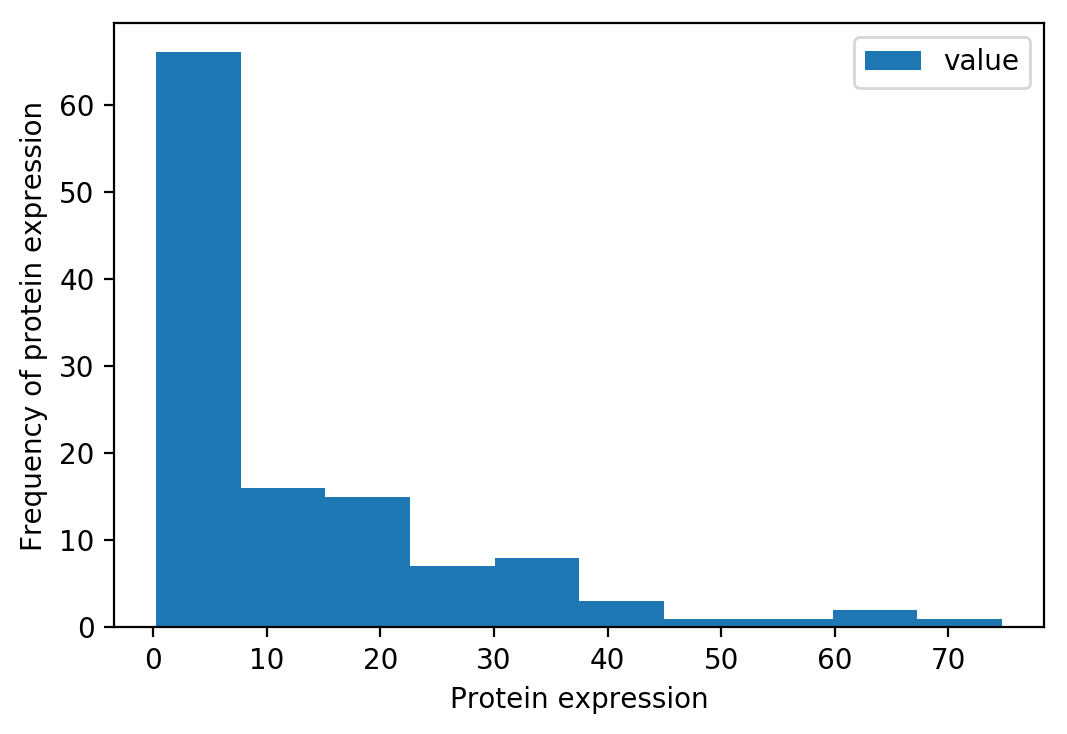

In [17]:
g = prot_vals.plot.hist('values')
g.figure.dpi = 200
g.axes.set_xlabel('Protein expression')
g.axes.set_ylabel('Frequency of protein expression')

In [5]:
top = "./"
cohort_names = ['patient_cohort_1','patient_cohort_2','patient_cohort_3']

data_dirs = {}
for cohort in cohort_names:
    data_dirs[cohort] = top+"sample_data/"+cohort
    
file_dirs = {}
for cohort in cohort_names:
    file_dirs[cohort] = top+"sample_data/"+cohort+"/"

replicates_files = {}
for cohort in cohort_names:
    replicates_files[cohort] = "df_replicates.tsv"

#samples_files = {}
#for cohort in cohort_names:
#    samples_files[cohort] = "df_samples.tsv"

sample_groups_files = {}
for cohort in cohort_names:
    sample_groups_files[cohort] = "df_sample_groups.tsv"
    
references = {}
for cohort in cohort_names:
    references[cohort] = "ref"
    
treatments = {}
for cohort in cohort_names:
    treatments[cohort] = "trt"

objs = {}
for cohort_name in cohort_names:
    objs[cohort_name] = cohorts.Cohort(cohort=cohort_name,
                                       marker_type="protein",
                                       data_dir=data_dirs[cohort_name],
                                       file_dir=file_dirs[cohort_name],
                                       replicates_file=replicates_files[cohort_name],
                                       #sample_files=sample_files[cohort],
                                       sample_groups_file= \
                                           sample_groups_files[cohort_name],
                                       reference=references[cohort_name],
                                       treatment=treatments[cohort_name])

In [6]:
integrated = cohorts.IntegratedCohort(cohorts = objs)

In [7]:
integrated.integrate_cohorts(dataset_type='raw_samples')

In [8]:
X = integrated.df.T

In [9]:
Y = integrated.df_groups.loc['trt']

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from scipy import interp
import matplotlib.pyplot as plt

In [25]:
cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
inter = 100
fprs = np.linspace(0, 1, inter)
tprs = []
for train, test in cv.split(X, Y):
    y_score =  (LogisticRegression(C=10,penalty='l1').
                  fit(X.iloc[train],Y.iloc[train]).
                  predict(X.iloc[test]))
    fpr, tpr, _ = roc_curve(Y.iloc[test],y_score,1)
    tprs.append(interp(fprs, fpr, tpr))
    tprs[-1][0] = 0.0
mean_tpr = np.mean(tprs, axis=0)

Text(0.5,0,'1 - Sensitivity')

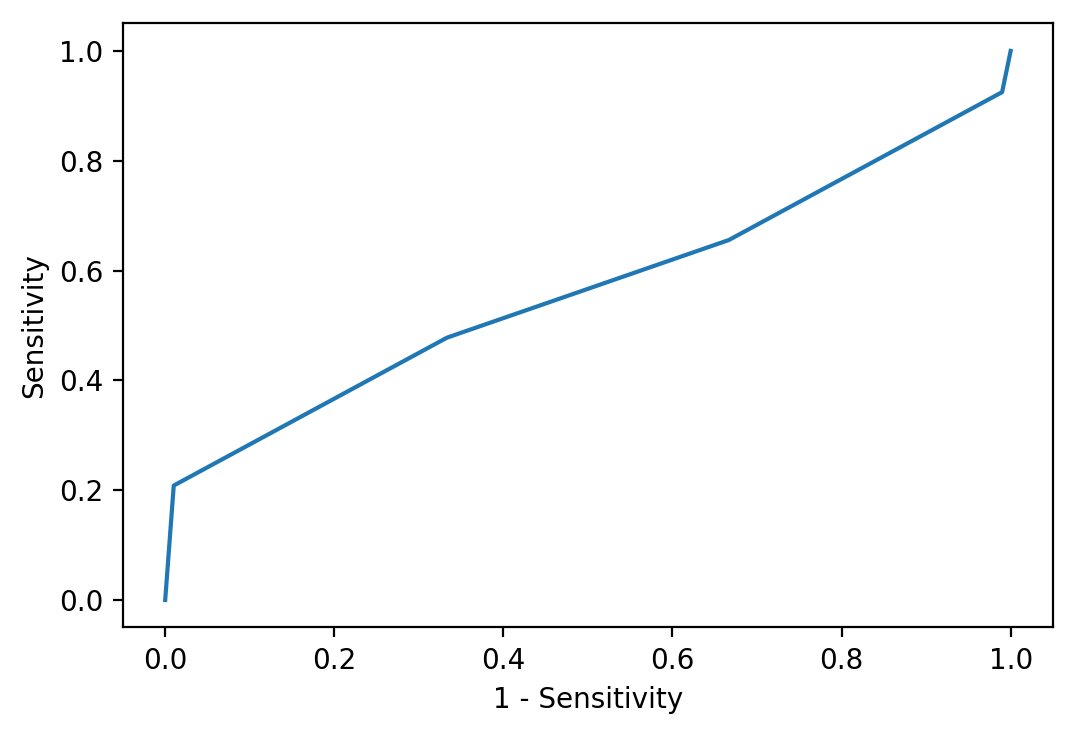

In [26]:
fig,ax=plt.subplots(dpi=200)
ax.plot(fprs,mean_tpr)
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1 - Sensitivity')